# Excercises - Word2Vec Friends

## Import Libraries

In [27]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import defaultdict
import spacy
import logging
import multiprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
!python3 -m spacy download en_core_web_sm 
import en_core_web_sm

%matplotlib inline
sns.set_style("darkgrid")

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [28]:
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## Data Import

In [29]:
# Data can be found at https://www.kaggle.com/datasets/kimmik123/friends-scriptcsv
df = pd.read_csv('./Friends_script.csv')
df.head()

,Name,Lines
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hum..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."


## Data Preparation

In [30]:
print("Columns cointaining 'na' values:\n")
print(df.isna().any())
print('\n----------------------------------------------------\n')
print("Count of 'na' values per column:\n")
print(df.isna().sum())

Columns cointaining 'na' values:

Name     True
Lines    True
dtype: bool

----------------------------------------------------

Count of 'na' values per column:

Name      1
Lines    32
dtype: int64


In [31]:
def remove_missing_values(df):
    missing_values = df.isnull().sum()
    df = df.dropna(axis=0)
    print("Removed {} missing values".format(missing_values.sum()))
    return df

df = remove_missing_values(df)

print("Columns cointaining 'na' values:\n")
print(df.isna().any())
print('\n----------------------------------------------------\n')
print("Count of 'na' values per column:\n")
print(df.isna().sum())

Removed 33 missing values
Columns cointaining 'na' values:

Name     False
Lines    False
dtype: bool

----------------------------------------------------

Count of 'na' values per column:

Name     0
Lines    0
dtype: int64


## Data Cleaning

In [32]:
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser']) # disabling Named Entity Recognition for speed     # doc needs to be a spacy Doc object
def cleaning(doc):
    # Lemmatizes and removes stopwords
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [33]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['Lines'])

In [34]:
%%time
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

CPU times: user 42.5 s, sys: 1.28 s, total: 43.8 s
Wall time: 43.9 s


In [35]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(31112, 1)

## Create Bigrams

In [36]:
sent = [row.split() for row in df_clean['clean']]

In [37]:
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
# Phraser() cuts down memory consumption of Phrases()

INFO - 16:11:25: collecting all words and their counts
INFO - 16:11:25: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:11:25: PROGRESS: at sentence #10000, processed 64665 words and 42758 word types
INFO - 16:11:25: PROGRESS: at sentence #20000, processed 129148 words and 72375 word types
INFO - 16:11:25: PROGRESS: at sentence #30000, processed 193284 words and 101290 word types
INFO - 16:11:25: collected 104264 token types (unigram + bigrams) from a corpus of 200072 words and 31112 sentences
INFO - 16:11:25: merged Phrases<104264 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 16:11:25: Phrases lifecycle event {'msg': 'built Phrases<104264 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2024-03-28T16:11:25.570853', 'gensim': '4.3.2', 'python': '3.9.6 (default, Feb  3 2024, 15:58:27) \n[Clang 15.0.0 (clang-1500.3.9.4)]', 'platform': 'macOS-14.3.1-arm64-arm-64bit', 'event': 'created'}
INFO - 16:11:25: exp

In [38]:
sentences = bigram[sent] # Transform the corpus based on the bigrams detected

## Show Most Frequent Words

In [39]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'not', 'know', 'okay', 'yeah', 's', 'like', 'think', 'right', 'go_to']

## Model Training

In [40]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [41]:
w2v_model = Word2Vec(min_count=20, window=2, vector_size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)

INFO - 16:11:25: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2024-03-28T16:11:25.781195', 'gensim': '4.3.2', 'python': '3.9.6 (default, Feb  3 2024, 15:58:27) \n[Clang 15.0.0 (clang-1500.3.9.4)]', 'platform': 'macOS-14.3.1-arm64-arm-64bit', 'event': 'created'}


In [42]:
%%time
w2v_model.build_vocab(sentences, progress_per=10000)
## Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them)

INFO - 16:11:25: collecting all words and their counts
INFO - 16:11:25: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:11:25: PROGRESS: at sentence #10000, processed 63091 words, keeping 6158 word types
INFO - 16:11:25: PROGRESS: at sentence #20000, processed 125925 words, keeping 8523 word types
INFO - 16:11:25: PROGRESS: at sentence #30000, processed 188482 words, keeping 10989 word types
INFO - 16:11:25: collected 11228 word types from a corpus of 195066 raw words and 31112 sentences
INFO - 16:11:25: Creating a fresh vocabulary
INFO - 16:11:25: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 1066 unique words (9.49% of original 11228, drops 10162)', 'datetime': '2024-03-28T16:11:25.899474', 'gensim': '4.3.2', 'python': '3.9.6 (default, Feb  3 2024, 15:58:27) \n[Clang 15.0.0 (clang-1500.3.9.4)]', 'platform': 'macOS-14.3.1-arm64-arm-64bit', 'event': 'prepare_vocab'}
INFO - 16:11:25: Word2Vec lifecycle event {'msg': 'effective_min_count=20 

CPU times: user 128 ms, sys: 2.89 ms, total: 131 ms
Wall time: 133 ms


In [43]:
%%time
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

INFO - 16:11:25: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 1066 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2024-03-28T16:11:25.926590', 'gensim': '4.3.2', 'python': '3.9.6 (default, Feb  3 2024, 15:58:27) \n[Clang 15.0.0 (clang-1500.3.9.4)]', 'platform': 'macOS-14.3.1-arm64-arm-64bit', 'event': 'train'}
INFO - 16:11:26: EPOCH 0: training on 195066 raw words (42406 effective words) took 0.2s, 184597 effective words/s
INFO - 16:11:26: EPOCH 1: training on 195066 raw words (42373 effective words) took 0.1s, 312278 effective words/s
INFO - 16:11:26: EPOCH 2: training on 195066 raw words (42785 effective words) took 0.1s, 319915 effective words/s
INFO - 16:11:26: EPOCH 3: training on 195066 raw words (42507 effective words) took 0.1s, 316399 effective words/s
INFO - 16:11:26: EPOCH 4: training on 195066 raw words (42373 effective words) took 0.2s, 191831 effective words/s
INFO - 16:11:26: EPOCH 5

CPU times: user 9.46 s, sys: 44.6 ms, total: 9.51 s
Wall time: 4.88 s


(1276702, 5851980)

In [44]:
w2v_model.init_sims(replace=True)

/var/folders/dv/t9jbtc_n21l7bcwt03cw661h0000gn/T/ipykernel_925/514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
WARNING - 16:11:30: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


## Model Exploration

In [45]:
w2v_model.wv.most_similar(positive=["joey"])

[('congratulation', 0.9892475008964539),
 ('realise', 0.9874247312545776),
 ('hang', 0.9872455596923828),
 ('yell', 0.9871485233306885),
 ('complicated', 0.9870477914810181),
 ('have_sex', 0.9868921637535095),
 ('explain', 0.9866656064987183),
 ('pheebs', 0.9865983724594116),
 ('lucky', 0.9865489602088928),
 ('bum', 0.9862827062606812)]

In [46]:
w2v_model.wv.most_similar(positive=["joey_tribbiani"])

[('business', 0.9951638579368591),
 ('movie', 0.9946733713150024),
 ('yes_yes', 0.9944772720336914),
 ('choice', 0.9944541454315186),
 ('certain', 0.9942935109138489),
 ('princess', 0.9941666126251221),
 ('class', 0.9939086437225342),
 ('roger', 0.9938875436782837),
 ('buddy', 0.9937801361083984),
 ('step', 0.9937230944633484)]

In [47]:
w2v_model.wv.most_similar(positive=["chandler"])

[('name', 0.9939336180686951),
 ('uhh', 0.9933708906173706),
 ('ridiculous', 0.992933452129364),
 ('sister', 0.9926555752754211),
 ('girl', 0.9926131367683411),
 ('nanny', 0.9922562837600708),
 ('judge', 0.9921589493751526),
 ('lie', 0.9921126961708069),
 ('goodbye', 0.9920440912246704),
 ('sense', 0.9919624924659729)]

In [48]:
w2v_model.wv.similarity('joey', 'food')

0.96329856

In [49]:
w2v_model.wv.similarity('ross', 'mark')

0.9008877

In [50]:
w2v_model.wv.doesnt_match(['ross', 'rachel', 'gunther'])

'gunther'

In [51]:
w2v_model.wv.doesnt_match(["rachel", "monica", "joey"])

'joey'

In [52]:
w2v_model.wv.doesnt_match(['ross', 'monica', 'janice'])

'janice'

In [53]:
w2v_model.wv.most_similar(positive=["woman", "chandler"], negative=["monica"], topn=3)

[('time', 0.9875221252441406),
 ('lot', 0.9872128963470459),
 ('thing', 0.9871855974197388)]

In [54]:
w2v_model.wv.most_similar(positive=["woman", "joey"], negative=["man"], topn=3)

[('uncomfortable', 0.9802957773208618),
 ('believe', 0.9800920486450195),
 ('go', 0.9795851707458496)]

In [55]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 19 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    ext = 0
    plt.xlim(Y[:, 0].min()-ext, Y[:, 0].max()+ext)
    plt.ylim(Y[:, 1].min()-ext, Y[:, 1].max()+ext)

    plt.title('t-SNE visualization for {}'.format(word.title()))

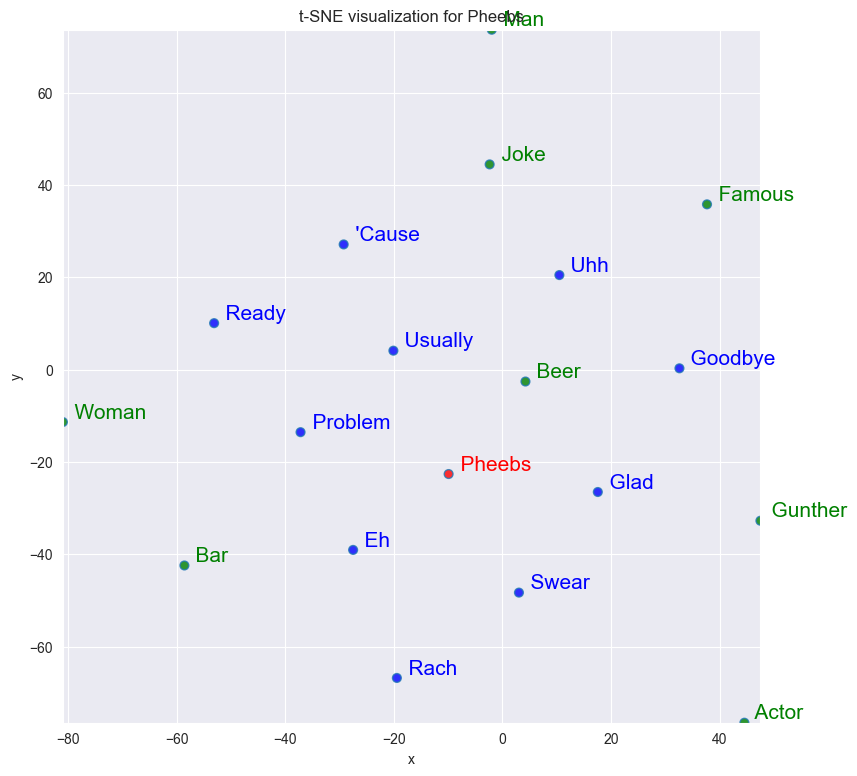

In [56]:
tsnescatterplot(w2v_model, 'pheebs', ['actor', 'joke', 'famous', 'man', 'woman', 'bar', 'gunther', 'beer'])

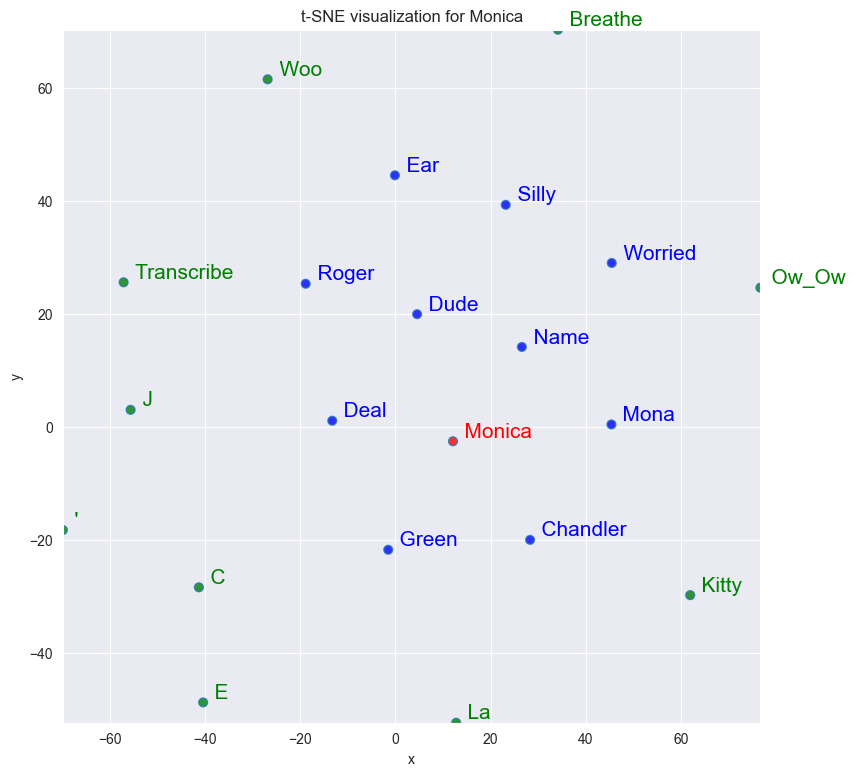

In [57]:
tsnescatterplot(w2v_model, 'monica', [i[0] for i in w2v_model.wv.most_similar(negative=["monica"])])

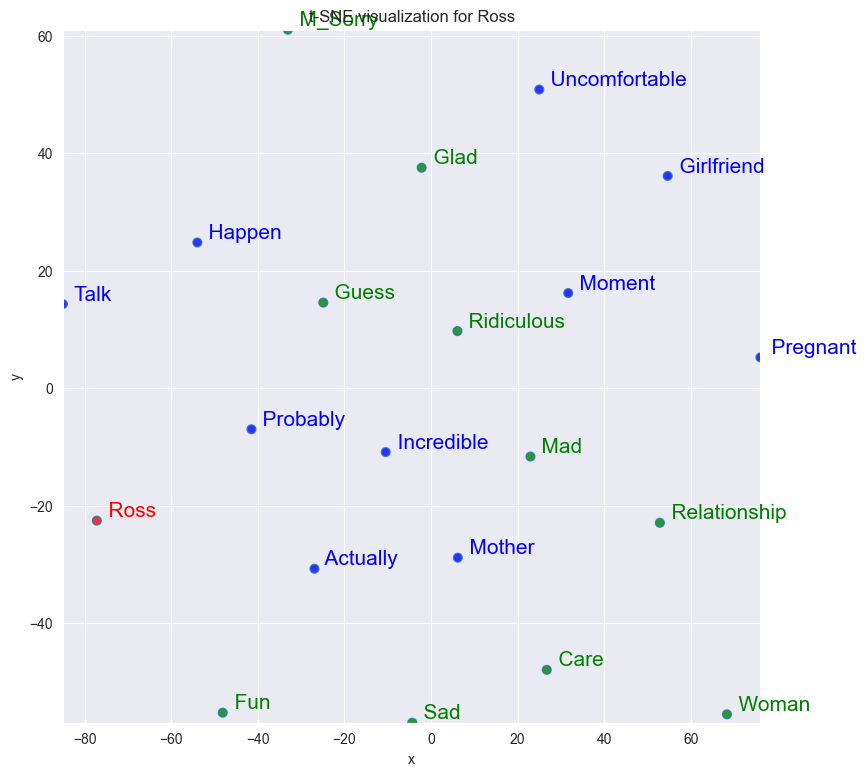

In [58]:
tsnescatterplot(w2v_model, "ross", [t[0] for t in w2v_model.wv.most_similar(positive=["ross"], topn=20)][10:])